<a href="https://colab.research.google.com/github/joaomarciel2/auxilio_moradia/blob/main/sistema_recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparar o ambiente no Colab

Instalação e Importação das bibliotecas necessárias

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

### Preparar os dados
Você precisa ter uma pasta com subpastas para cada categoria de produto

In [6]:
!unzip -q /content/dataset.zip -d /content/dataset

In [7]:
dataset_path = '/content/dataset'

# Listar classes
classes = os.listdir(dataset_path)
print("Classes encontradas:", classes)

Classes encontradas: ['tshirt', 'watch']


### Carregar um modelo pré-treinado

Para extrair características visuais, será utilizado um modelo pré-treinado da ResNet50, remvoendo a camada final (classificação) para obter embeddings das imagens.

In [8]:
# Carregar ResNet50 pré-treinado sem a camada de classificação

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print(base_model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


### Extrair embeddings das imagens

Transformação de cada imagem em um vetor que representa sua aparência visual.

In [9]:
def preprocess_img(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = resnet50.preprocess_input(img_array)
  return img_array

image_embeddings = {}

target_classes = ['watch', 'tshirt']

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    # Se for 'watch' ou 't-shirt', pega só as primeiras 1000 imagens
    if class_name in target_classes:
        img_list = os.listdir(class_path)[:1000]
    else:
        img_list = os.listdir(class_path)

    for img_name in img_list:
        img_path = os.path.join(class_path, img_name)
        img_array = preprocess_img(img_path)
        embedding = base_model.predict(img_array, verbose=0)
        image_embeddings[img_path] = embedding


### Calcular similaridade entre imagens

Uso da similaridade do cosseno para encontrar imagens mais parecidas.

In [11]:
def find_similar_images(query_img_path, embeddings, top_k=3):
    query_embedding = embeddings[query_img_path]
    similarities = {}

    for img_path, emb in embeddings.items():
        if img_path == query_img_path:
            continue
        sim = cosine_similarity(query_embedding, emb)[0][0]
        similarities[img_path] = sim

    # Ordenar pelas mais similares
    similar_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return similar_images

### Testando o sistema e visualizar resultados

Selecionar uma imagem de consulta e mostrar as imagens mais semelhantes.

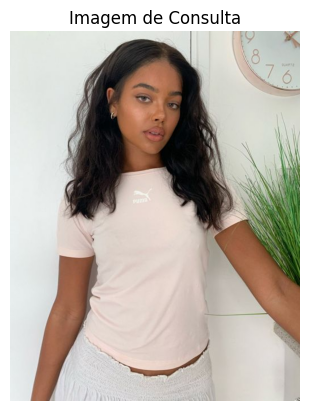

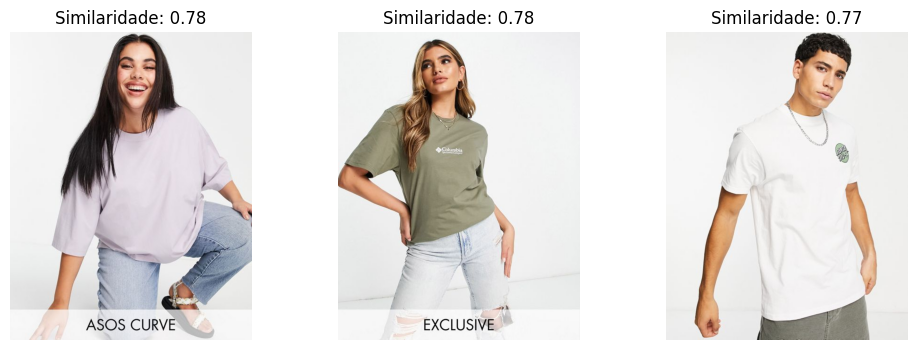

In [12]:
query_img = '/content/dataset/tshirt/173.jpg'
top_matches = find_similar_images(query_img, image_embeddings, top_k=3)

# Mostrar imagem de consulta
plt.imshow(image.load_img(query_img))
plt.title("Imagem de Consulta")
plt.axis('off')
plt.show()

# Mostrar imagens mais semelhantes
plt.figure(figsize=(12, 4))
for i, (img_path, sim) in enumerate(top_matches):
  plt.subplot(1, 3, i+1)
  plt.imshow(image.load_img(img_path))
  plt.title(f"Similaridade: {sim:.2f}")
  plt.axis('off')
plt.show()